In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Iterations that were run: 27


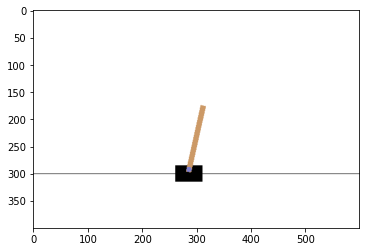

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

### Off-policy Monte Carlo Control

In [ ]:
from collections import defaultdict

In [ ]:
# Transform the continuous state into a discretized state
# Reference: http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf
def discretize_state(state):
  state_discretized_vector = np.zeros(4)
  
  # Discretize x (position)
  if abs(state[0]) <= 0.8:
    state_discretized_vector[0] = 1
  elif state[0] < -0.8:
    state_discretized_vector[0] = 0
  elif state[0] > 0.8:
    state_discretized_vector[0] = 2

  # Discretize x’ (velocity)
  if abs(state[1]) <= 0.5:
    state_discretized_vector[1] = 1
  elif state[1] < -0.5:
    state_discretized_vector[1] = 0
  elif state[1] > 0.5:
    state_discretized_vector[1] = 2

  # Discretize theta (angle)
  angle = 180/3.1428*state[2]
  if -12 < angle <= -6:
    state_discretized_vector[2] = 0
  elif -6 < angle <= -1:
    state_discretized_vector[2] = 1
  elif -1 < angle <= 0:
    state_discretized_vector[2] = 2
  elif 0 < angle <= 1:
    state_discretized_vector[2] = 3
  elif 1 < angle <= 6:
    state_discretized_vector[2] = 4
  elif 6 < angle <= 12:
    state_discretized_vector[2] = 5

  # Discretize theta’ (angular velocity)
  if abs(state[3]) <= 50:
    state_discretized_vector[3] = 1
  elif state[3] < -50:
    state_discretized_vector[3] = 0
  elif state[3] > 50:
    state_discretized_vector[3] = 2
  
  state_discretized = int(state_discretized_vector[0]*54 + state_discretized_vector[1]*18 + state_discretized_vector[2]*3 + state_discretized_vector[3])

  return state_discretized

In [ ]:
# Obtain an action based on the policy
def select_action_from_policy(state, policy):
  return np.random.choice(action_space, p=[policy[(state, a)] for a in action_space])

In [ ]:
# Define a function to generate the episode
def generate_episode(policy):
  sequence = []
  done = True
  while True:
    if done:
      state, reward, done = env.reset(), None, False
      state = discretize_state(state)
    else:
      state, reward, done, _ = env.step(action)
      state = discretize_state(state)
    action = select_action_from_policy(state, policy)
    sequence.append((reward, state, action, done)) 
    if done:
      break

  return sequence, len(sequence)-1 

In [ ]:
# Choose the best action with tie-breaking
def argmax_tie_break(arr):
  return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [ ]:
# Define the off-policy Monte Carlo control
def mc_control_off_policy(episodes, gamma):
  Q = defaultdict(float)
  C = defaultdict(int)
  pi = defaultdict(int)

  for episode in range(episodes):
    b = defaultdict(lambda: 1 / num_states)
    sequence, T = generate_episode(b)
    G = 0
    W = 1
    for t in range(T-1, -1, -1):
      state_t, action_t = sequence[t][1], sequence[t][2]
      reward_t1 = sequence[t+1][0]
      G = gamma * G + reward_t1
      C[(state_t, action_t)] = C[(state_t, action_t)] + W
      Q[(state_t, action_t)] = Q[(state_t, action_t)] + (W / C[(state_t, action_t)]) * (G - Q[(state_t, action_t)])
      pi[state_t] = argmax_tie_break([Q[(state_t, action_t)] for a in range(num_states)])
      if action_t != pi[state_t]:
        break
      W = W / b[(state_t, action_t)]
  
  return pi

In [ ]:
# Define the number of states and the action-space
num_states = 2
action_space = [0,1]

In [ ]:
# Obtain the policy from the off-policy Monte Carlo control, by using 1500 episodes and a discount value of 0.94
pi = mc_control_off_policy(1500, 0.94)

Iterations that were run: 131


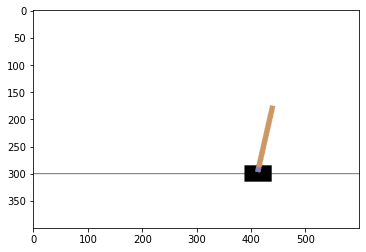

In [ ]:
env = gym.make("CartPole-v0")
state = env.reset()
state = discretize_state(state)
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  # Choose 
  action = pi[state]
  print("step i",i,"action=",action)
  state, reward, done, info = env.step(action)
  state = discretize_state(state)
  print("state=",state,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

The number of iterations was increased from 27 to 131.